In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from IPython.core.debugger import Tracer
from scipy.ndimage.measurements import label

images = glob.glob('../test_images/*.jpg')

C:\Users\sbuggave\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spat_func= True,hist_func= True,hog_func= True):
    #Tracer()()
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        file_features=[]
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spat_func==True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_func==True:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            file_features.append(hist_features)
        
        if hog_func==True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

number of car images: 8792
number of non-car images: 8968


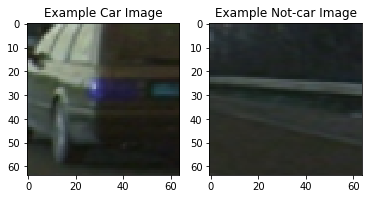

In [6]:
cars = glob.glob("./vehicles/vehicles/*/*.png")
notcars = glob.glob("./non-vehicles/non-vehicles/*/*.png")
print("number of car images:",len(cars))
print("number of non-car images:",len(notcars))

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])

# Plot the examples
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()


C:\Users\sbuggave\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


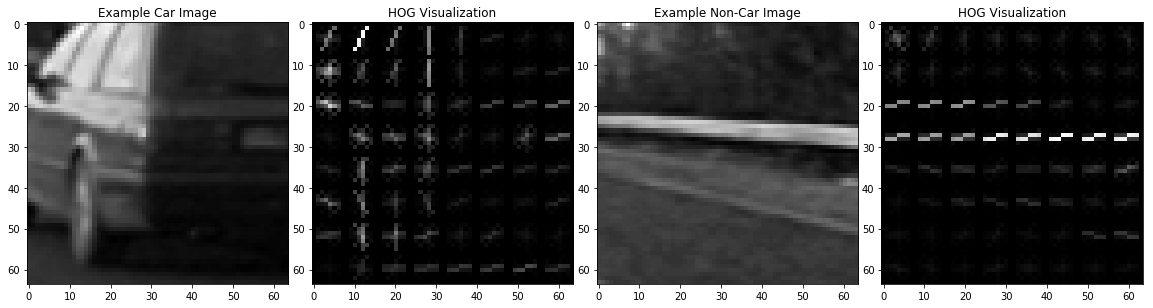

"\nplt.subplot(245)\nplt.imshow(car_gray, cmap='gray')\nplt.title('Example Car Image')\nplt.subplot(246)\nplt.imshow(features, cmap='gray')\nplt.title('HOG Visualization')\nplt.subplot(247)\nplt.imshow(notcar_gray, cmap='gray')\nplt.title('Example Non-Car Image')\nplt.subplot(248)\nplt.imshow(notcar_features, cmap='gray')\nplt.title('HOG Visualization')\nplt.show()"

In [7]:
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig, axs = plt.subplots(1,4, figsize=(20,5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.09)
plt.subplot(141)
plt.imshow(car_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(142)
plt.imshow(car_hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(143)
plt.imshow(notcar_gray, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(144)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()
'''
plt.subplot(245)
plt.imshow(car_gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(246)
plt.imshow(features, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(247)
plt.imshow(notcar_gray, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(248)
plt.imshow(notcar_features, cmap='gray')
plt.title('HOG Visualization')
plt.show()'''

In [8]:
# Define HOG parameters
cspace_in='YCrCb'
orient_in = 11
pix_per_cell_in = 16
cell_per_block_in = 2
spatial=32
histbin=32
hog_func_in=True
hist_func_in=True
spatial_func_in=True
# Call our function with vis=True to see an image output
car_features = extract_features(cars, cspace=cspace_in, spatial_size=(spatial, spatial),hist_bins=histbin, 
                                hist_range=(0, 256),orient=orient_in, pix_per_cell=pix_per_cell_in,
                                cell_per_block=cell_per_block_in, hog_channel='ALL',spat_func= spatial_func_in,
                                hist_func= hist_func_in,hog_func= hog_func_in)
notcar_features = extract_features(notcars, cspace=cspace_in, spatial_size=(spatial, spatial),hist_bins=histbin, 
                                hist_range=(0, 256),orient=orient_in, pix_per_cell=pix_per_cell_in,
                                cell_per_block=cell_per_block_in, hog_channel='ALL',spat_func= spatial_func_in,
                                hist_func= hist_func_in,hog_func= hog_func_in)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Users\sbuggave\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4356
10.22 Seconds to train SVC...
Test Accuracy of SVC =  0.987
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
0.002 Seconds to predict 10 labels with SVC


In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

C:\Users\sbuggave\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


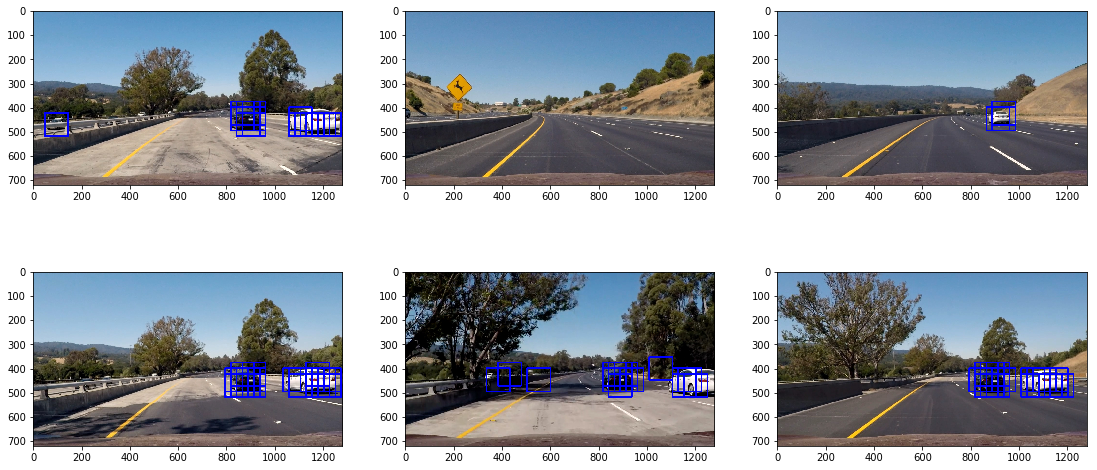

In [10]:
y_start_stop = [350, 640]
t=time.time()

test_images=glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(2,3, figsize=(20,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs=axs.ravel()

for i,test_image in enumerate(test_images):
    image = mpimg.imread(test_image)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace_in, 
                            spatial_size=(spatial,spatial), hist_bins=histbin, 
                            orient=orient_in, pix_per_cell=pix_per_cell_in, 
                            cell_per_block=cell_per_block_in, 
                            hog_channel='ALL', spatial_feat=spatial_func_in, 
                            hist_feat=hist_func_in, hog_feat=hog_func_in)                      

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    axs[i].imshow(window_img)
    
plt.show()

In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    b_boxes=[]
    
#    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((spatial_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                #print(scale)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                b_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img,b_boxes

3
7
10
13
18
22
24
24


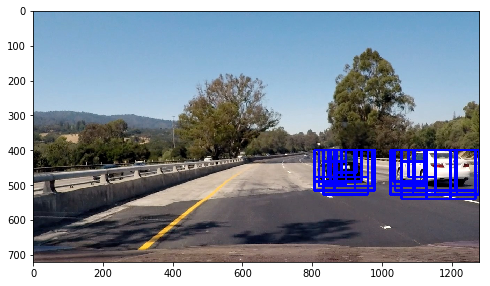

In [32]:
ystart = 400
ystop = 640
xstart = 300
xstop = 1280
scale = 1.2

img = mpimg.imread('./test_images/test4.jpg')

box_list = []

for i in np.arange(1.0,2.5,0.2):
    scale = i
    out_img, b_boxes = find_cars(img, ystart, ystop,scale, svc, X_scaler, 
                    orient=orient_in, pix_per_cell=pix_per_cell_in, cell_per_block=cell_per_block_in, spatial_size=(spatial,spatial), hist_bins=histbin)
    box_list+=b_boxes
    print(len(box_list))

img_copy=np.copy(img)
for i in box_list:
    cv2.rectangle(img_copy,i[0],i[1],(0,0,255),6)
#print(box_list[1])
#print(box_list[0][0])
#print(box_list)
plt.figure(figsize=(8,8))
plt.imshow(img_copy)
plt.show()

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [19]:
def pipeline_sliding_window_search(img):
    ystart = 400
    ystop = 640
    box_list = []

    image = img.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=cspace_in, 
                            spatial_size=(spatial,spatial), hist_bins=histbin, 
                            orient=orient_in, pix_per_cell=pix_per_cell_in, 
                            cell_per_block=cell_per_block_in, 
                            hog_channel='ALL', spatial_feat=spatial_func_in, 
                            hist_feat=hist_func_in, hog_feat=hog_func_in)      
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img,heatmap

"    \nfig = plt.figure()\nplt.subplot(121)\nplt.imshow(img_copy)\nplt.title('Car Positions')\nplt.subplot(122)\nplt.imshow(heatmap, cmap='hot')\nplt.title('Heat Map')\n#fig.tight_layout()\nplt.show()"

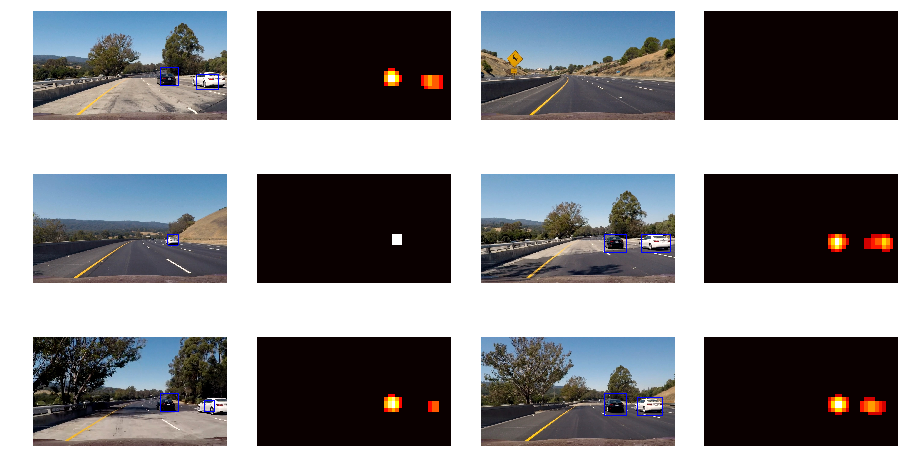

In [29]:
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()
j=0
for img in test_images:
    draw_img,heatmap=pipeline_sliding_window_search(mpimg.imread(img))
    axs[j].imshow(draw_img)
    axs[j].axis('off')
    j=j+1
    axs[j].imshow(heatmap,cmap='hot')
    axs[j].axis('off')
    j=j+1
plt.show()

In [30]:
def pipeline_hogsubsampling(img):
    ystart = 400
    ystop = 640
    box_list = []
    
    for i in np.arange(1.0,2.5,0.2):
        scale = i
        out_img, b_boxes = find_cars(img, ystart, ystop,scale, svc, X_scaler, 
                        orient=orient_in, pix_per_cell=pix_per_cell_in, cell_per_block=cell_per_block_in, spatial_size=(spatial,spatial), hist_bins=histbin)
        box_list+=b_boxes
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img,heatmap

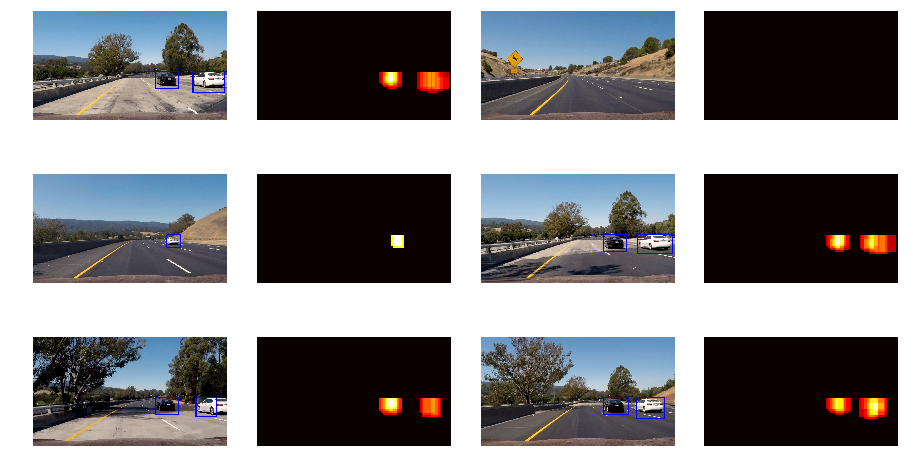

In [31]:
test_images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(3, 4, figsize=(16,8))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

j=0
for img in test_images:
    draw_img,heatmap=pipeline_hogsubsampling(mpimg.imread(img))
    axs[j].imshow(draw_img)
    axs[j].axis('off')
    j=j+1
    axs[j].imshow(heatmap,cmap='hot')
    axs[j].axis('off')
    j=j+1
    
plt.show()

In [84]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = './test_video_slidingwindow_output.mp4'
clip1 = VideoFileClip("./test_video.mp4")
write_clip = clip1.fl_image(pipeline_sliding_window_search) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video ./test_video_slidingwindow_output.mp4
[MoviePy] Writing video ./test_video_slidingwindow_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:58<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_slidingwindow_output.mp4 

Wall time: 59.3 s


In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output2 = './project_video_hogsubsamp.mp4'
clip2 = VideoFileClip('project_video.mp4')
write_clip2 = clip2.fl_image(pipeline_hogsubsampling) 
%time write_clip2.write_videofile(write_output2, audio=False)

[MoviePy] >>>> Building video ./project_video_hogsubsamp.mp4
[MoviePy] Writing video ./project_video_hogsubsamp.mp4


100%|█████████████████████████████████████▉| 1260/1261 [23:02<00:01,  1.09s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_hogsubsamp.mp4 

Wall time: 23min 2s
